In [1]:
import sys
import matplotlib.pyplot as plt
import cv2
sys.path.append('../')

from scripts.point_cloud_utils import send_point_cloud
from pyngp.common import *
from tqdm import tqdm
import pyngp.pyngp as ngp
from  scripts.ros_utils import get_image_tf_pair




In [2]:
width = 854
height = 480
spp = 1 # 1 is fast 8 is default

objects = ['table', 'truck', 'block']
testbed_map = {}
for obj in objects:
    testbed = ngp.Testbed()
    testbed.load_snapshot(f'../nerf/{obj}.ingp')
    testbed_map[obj] = testbed
def srgb_to_linear(img):
    limit = 0.04045
    return np.where(img > limit, np.power((img + 0.055) / 1.055, 2.4), img / 12.92)

def linear_to_srgb(img):
    limit = 0.0031308
    return np.where(img > limit, 1.055 * (img ** (1.0 / 2.4)) - 0.055, 12.92 * img)

camera_matrix = testbed_map['table'].camera_matrix


14:18:29 SUCCESS  Initialized CUDA 12.0. Active GPU is #0: NVIDIA GeForce RTX 4090 [89]
14:18:29 INFO     Loading network snapshot from: ../nerf/table.ingp
14:18:33 DEBUG    GPUMemory: allocating 1.41 KB.
14:18:33 DEBUG    GPUMemory: allocating 144 B.
14:18:33 DEBUG    GPUMemory: allocating 144 B.
14:18:33 DEBUG    GPUMemory: allocating 144 B.
14:18:33 DEBUG    GPUMemory: allocating 144 B.
14:18:33 DEBUG    GPUMemory: allocating 8 B.
14:18:33 DEBUG    GPUMemory: allocating 1.12 KB.
14:18:33 DEBUG    GPUMemory: allocating 4 MB.
14:18:33 DEBUG    GPUMemory: allocating 8 MB.
14:18:33 DEBUG    GPUMemory: allocating 2 MB.
14:18:33 DEBUG    GPUMemory: allocating 64 KB.
14:18:33 INFO     GridEncoding:  Nmin=16 b=2 F=4 T=2^22 L=8
14:18:33 DEBUG    GridEncoding at level 0: resolution=16 params_in_level=4096
14:18:33 DEBUG    GridEncoding at level 1: resolution=32 params_in_level=32768
14:18:33 DEBUG    GridEncoding at level 2: resolution=64 params_in_level=262144
14:18:33 DEBUG    GridEncoding 

In [23]:
ros_image, tf = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
tf = tf[0]
ros_image = ros_image[0]

c2w = tf.copy()
c2w[0:3, 2] *= -1  # flip the y and z axis
c2w[0:3, 1] *= -1
c2w = c2w[[1, 0, 2, 3], :]
c2w[2, :] *= -1  # flip whole world upside down
tf_ngp = c2w
tf_ngp = tf_ngp[:-1, :]

testbed.set_nerf_camera_matrix(tf_ngp)
camera_matrix2 = testbed.camera_matrix.copy()

depth_buffer = 10000000*np.ones((height, width))
image_composed = np.zeros((height, width, 3))



for obj in objects:
    testbed = testbed_map[obj]
    camera_matrix_tmp = camera_matrix2.copy()
    if obj != 'table':
        tmp = (.2*(np.random.rand(3, 1)-.5) ).squeeze()
        tmp[2] = 0
        camera_matrix_tmp[:, -1] = camera_matrix_tmp[:, -1] + camera_matrix_tmp[:, :3] @ tmp
    testbed.camera_matrix = camera_matrix_tmp
    testbed.nerf.render_min_transmittance = 0.01
    testbed.render_mode = ngp.RenderMode.Shade
    testbed.color_space = ngp.ColorSpace.Linear
    image = testbed.render(width, height, spp, True)
    testbed.nerf.render_min_transmittance = 0.9
    testbed.render_mode = ngp.RenderMode.Depth
    depth = testbed.render(width, height, spp, True)
    depth = depth[:,:,0]
    inds = (depth < depth_buffer) * (depth > 0.2)
    image_composed[inds, 0] = image[inds, 0]
    image_composed[inds, 1] = image[inds, 1]
    image_composed[inds, 2] = image[inds, 2]
    depth_buffer[inds] = depth[inds]

image_composed = linear_to_srgb(image_composed)


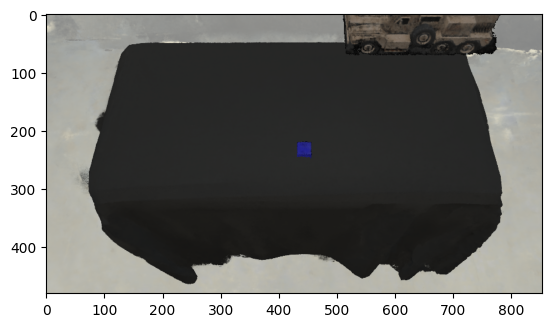

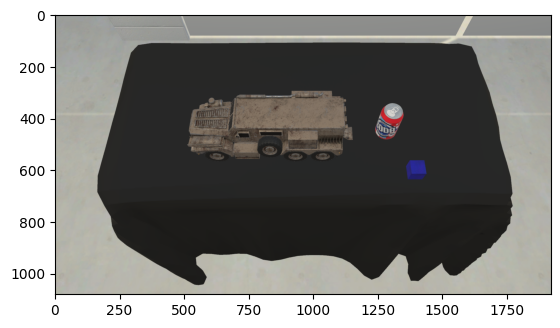

In [24]:
plt.figure()
plt.imshow(image_composed)
plt.figure()
plt.imshow(ros_image)

scale = 1.0
image_composed = cv2.resize(image_composed, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
ros_image = cv2.resize(ros_image, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC) 
tmp = np.max(depth_buffer)
depth_buffer = tmp*cv2.resize(depth_buffer/tmp, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR) 

In [25]:
import math
fov = math.pi*testbed.fov/180.0
fx = 2*np.tan(fov/2.0);
fy = fx*width/height;

Z = -depth_buffer;
[Xgrid, Ygrid] = np.meshgrid(np.linspace(-.5, .5, image_composed.shape[1]), np.linspace(-.5, .5, image_composed.shape[0]));

X = -(Xgrid)*Z/fx;
Y = (Ygrid)*Z/fy;
points = np.stack([X, Y, Z],axis=2);

print(points.shape)

points = np.reshape(points, (-1, 3))

# tf_cam_world = np.linalg.inv(tf)
tf_cam_world = tf

points = (tf_cam_world[:3, :3] @ points.transpose()) + np.reshape(tf_cam_world[:3, 3],(3,1))
points = points.transpose()

colors = np.reshape(image_composed, (-1, 3))
colors = np.hstack([colors, np.ones((colors.shape[0], 1))])

print(points.shape)
print(colors.shape)

send_point_cloud(np.hstack((points, colors)), has_alpha=False)

# points = points';  % camera coordinates
# points = pagemtimes(T(1:3, 1:3, :), points) + T(1:3, end, :); % world coordinates

(480, 854, 3)
(409920, 3)
(409920, 4)


In [26]:
sys.path.append('../unimatch_repo')

import torch
import torch.nn.functional as F
from unimatch.unimatch import UniMatch
from evaluate_flow import inference_flow
from utils.flow_viz import flow_to_image
from PIL import Image as im

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UniMatch(feature_channels=128,
                 num_scales=2,
                 upsample_factor=4,
                 num_head=1,
                 ffn_dim_expansion=4,
                 num_transformer_layers=6,
                 reg_refine=True,
                 task='flow').to(device)

trained_model_path = '../unimatch_repo/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth'
inference_dir = '../unimatch_repo/demo/nerf'
output_dir = '../unimatch_repo/output'



print(image_composed.shape)
data = im.fromarray((255*image_composed[:,:,:3]).astype(np.uint8))
data.save(f'{inference_dir}/image_composed.png')
data = im.fromarray(ros_image[:,:,:3])
data.save(f'{inference_dir}/ros_image.png')

loc = 'cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(trained_model_path, map_location=loc)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

(480, 854, 3)


UniMatch(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
    

0.10978341102600098


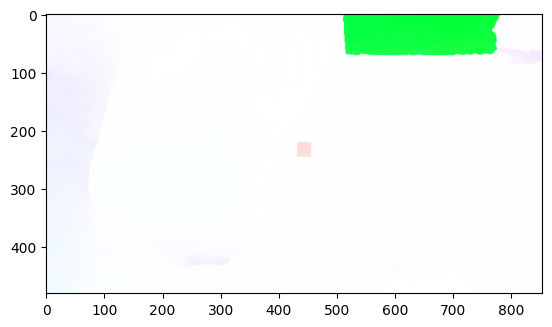

In [27]:
# from utils import frame_utils
# image1 = frame_utils.read_gen(filenames[test_id])
# image2 = frame_utils.read_gen(filenames[test_id + 1])
image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
image2 = ros_image[:,:,:3]
image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)

padding_factor=32

# the model is trained with size: width > height
transpose_img = False
if image1.size(-2) > image1.size(-1):
    image1 = torch.transpose(image1, -2, -1)
    image2 = torch.transpose(image2, -2, -1)
    transpose_img = True

nearest_size = [int(np.ceil(image1.size(-2) / padding_factor)) * padding_factor,
                int(np.ceil(image1.size(-1) / padding_factor)) * padding_factor]
fixed_inference_size = None
# fixed_inference_size = [val//2 for val in nearest_size] 
# fixed_inference_size = (224, 384)

# resize to nearest size or specified size
inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

assert isinstance(inference_size, list) or isinstance(inference_size, tuple)
ori_size = image1.shape[-2:]

# resize before inference
if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
    image1 = F.interpolate(image1, size=inference_size, mode='bilinear',
                           align_corners=True)
    image2 = F.interpolate(image2, size=inference_size, mode='bilinear',
                           align_corners=True)

    
for i in range(1):
    import time
    start = time.time()
    with torch.inference_mode():
        results_dict = model(image1, image2,
                            attn_type='swin',
                            attn_splits_list=[2, 8],
                            corr_radius_list=[-1, 4],
                            prop_radius_list=[-1, 1],
                            num_reg_refine=6,
                            task='flow'
                            )
    print(time.time() - start)

    
flow_pr = results_dict['flow_preds'][-1]

# resize back
if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
    flow_pr = F.interpolate(flow_pr, size=ori_size, mode='bilinear',
                            align_corners=True)
    flow_pr[:, 0] = flow_pr[:, 0] * ori_size[-1] / inference_size[-1]
    flow_pr[:, 1] = flow_pr[:, 1] * ori_size[-2] / inference_size[-2]

if transpose_img:
    flow_pr = torch.transpose(flow_pr, -2, -1)

flow = flow_pr[0].permute(1, 2, 0).cpu().numpy()  # [H, W, 2]

plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

In [28]:
import torch.nn as nn
import torch.nn.functional as F


def get_points(depth, tf_cam_world_inv, fov, width, height):
    fx = 2*np.tan(fov/2.0)
    fy = fx*width/height
    Z = depth
    [Xgrid, Ygrid] = np.meshgrid(np.linspace(-.5, .5, width), np.linspace(-.5, .5, height))
    X = (Xgrid)*Z/fx
    Y = (Ygrid)*Z/fy
    points = np.stack([X, Y, Z], axis=2);
    points = np.reshape(points, (-1, 3))
    points = (points @ tf_cam_world_inv[:3, :3].transpose()) + np.reshape(tf_cam_world_inv[:3, 3], (1, 3))
    
    return points

def render_nerf(testbed_map, tf_map, fov, width, height):
    all_points = []
    all_depth = []
    depth_buffer = 10000000*np.ones((height, width))
    image_composed = np.zeros((height, width, 3))
    
    for ind, obj in enumerate(testbed_map):
        testbed = testbed_map[obj]
        
        tf_nerf_cam = tf_map[obj]
        tf_cam_nerf = np.linalg.inv(tf_nerf_cam.detach().cpu().numpy())
        c2w = tf_cam_nerf.copy()
        c2w[0:3, 2] *= -1  # flip the y and z axis
        c2w[0:3, 1] *= -1
        c2w = c2w[[1, 0, 2, 3], :]
        c2w[2, :] *= -1  # flip whole world upside down
        tf_ngp = c2w
        tf_ngp = tf_ngp[:-1, :]
        testbed.set_nerf_camera_matrix(tf_ngp)
    
        testbed.nerf.render_min_transmittance = 0.01
        testbed.render_mode = ngp.RenderMode.Shade
        testbed.color_space = ngp.ColorSpace.Linear
        image = testbed.render(width, height, spp, True)
        testbed.nerf.render_min_transmittance = 0.9
        testbed.render_mode = ngp.RenderMode.Depth
        depth = testbed.render(width, height, spp, True)
        depth = depth[:, :, 0]
        depth[depth < 0.1]  = 10000000
        inds = (depth < depth_buffer)
        image_composed[inds, 0] = image[inds, 0]
        image_composed[inds, 1] = image[inds, 1]
        image_composed[inds, 2] = image[inds, 2]
        depth_buffer[inds] = depth[inds]
        
        all_depth.append(depth.flatten())
        points = get_points(depth, tf_cam_nerf, fov, width, height) 
        Rt_tensor = tf_nerf_cam[:3, :3].transpose(0, 1)
        p_tensor = tf_nerf_cam[:3, 3]
        points = torch.tensor(points, dtype=torch.float32, device='cuda', requires_grad=False)
        points_tensor = (points @ Rt_tensor) + torch.reshape(p_tensor, (1, 3)) # need grad
        all_points.append(points_tensor)
        
        
    all_points = torch.stack(all_points, axis=0)
    all_depth = torch.tensor(np.vstack(all_depth), dtype=torch.float32, device='cuda')
    min_z, inds = torch.min(all_depth, axis=0) # keepdim=True 
    
    x_vals = all_points[:, :, 0].flatten()
    y_vals = all_points[:, :, 1].flatten()
    z_vals = all_points[:, :, 2].flatten()
    
    inds = inds*inds.shape[0] + torch.linspace(0, inds.shape[0]-1, inds.shape[0], dtype=torch.int32, device='cuda')
    
    points_composed = torch.stack([x_vals[inds], y_vals[inds], z_vals[inds]], axis=1)
    image_composed = linear_to_srgb(image_composed)
    
    return image_composed, points_composed  



def get_transform(rpy_params, xyz_params):
#     rpy = torch.reshape(rpy, 3, 1, []);
    rpy_params = torch.reshape(rpy_params, (3,1))
    xyz_params = torch.reshape(xyz_params, (3,1)) 
    ct = torch.cos(rpy_params);
    st = torch.sin(rpy_params);
    R00 = ct[0]*ct[2]*ct[1] - st[0]*st[2]
    R01 = -ct[0]*ct[1]*st[2] - st[0]*ct[2]
    R02 = ct[0]*st[1]
    R10 = st[0]*ct[2]*ct[1] + ct[0]*st[2]
    R11 = -st[0]*ct[1]*st[2] + ct[0]*ct[2]
    R12 = st[0]*st[1]
    R20 = -st[1]*ct[2]
    R21 = st[1]*st[2]
    R22 = ct[1]
    R0 = torch.hstack([R00, R01, R02])
    R1 = torch.hstack([R10, R11, R12])
    R2 = torch.hstack([R20, R21, R22])
    R = torch.stack([R0, R1, R2], axis=0);
        
    row = torch.tensor([[0.0, 0.0, 0.0, 1.0]], dtype=torch.float32, device='cuda')
    M = torch.hstack([R, xyz_params])
    T = torch.vstack([M, row])
    return T

class CorrespondenceNet(nn.Module):
    def __init__(self, testbed_map, width, height, tf):
        super(CorrespondenceNet, self).__init__()
        self.testbed_map = testbed_map
        self.width = width
        self.height = height
        self.objects = [key for key in testbed_map.keys() ] # if key != 'table'
        self.rpy = nn.Parameter(.6*torch.rand(3*len(self.objects), dtype=torch.float32, device='cuda'))
        self.xyz = nn.Parameter(.2*torch.rand(3*len(self.objects), dtype=torch.float32, device='cuda'))
        self.fov = testbed_map['table'].fov
        assert all([testbed_map[key].fov == self.fov for key in testbed_map])
        self.fov = math.pi*self.fov/180.0
        self.tf_cam_world = torch.tensor(tf, dtype=torch.float32, device='cuda') 
        self.default_transforms = {}
        for obj in self.objects:
            T = np.linalg.inv(tf)
            self.default_transforms[obj] = torch.tensor(T, dtype=torch.float32, device='cuda')
        
    def forward(self): # should take this eventually tf_cam_world_map
        tf_map = {}
        ind = 0
        for obj in self.objects:
            default_transform = self.default_transforms[obj]
            if obj != 'table':
                tf_learned = get_transform(self.rpy[(ind)*3:(ind+1)*3], self.xyz[(ind)*3:(ind+1)*3])
                tf_nerf_cam = default_transform  @ tf_learned
                ind += 1
            else:
                tf_nerf_cam = default_transform
            tf_map[obj] = tf_nerf_cam
            
        image_composed, points_composed = render_nerf(self.testbed_map, tf_map, self.fov, self.width, self.height)
        
        Rt = self.tf_cam_world[:3, :3].transpose(0,1)
        points_composed_world = (points_composed @ Rt) + torch.reshape(self.tf_cam_world[:3, 3], (1, 3)) 
        
#         fx = 2*np.tan(self.fov/2.0)
#         fy = fx*self.width/self.height
#         x = -fx*points_composed[:, 0]/points_composed[:, 2];
#         y = -fy*points_composed[:, 1]/points_composed[:, 2];
        x = points_composed[:, 0]/points_composed[:, 2];
        y = points_composed[:, 1]/points_composed[:, 2];
        points_2d = torch.stack([x, y], axis=1)
        
        return image_composed, points_composed, points_composed_world, points_2d

def compute_loss(pred_points, target_points, uv, target_grid):
    loss = F.huber_loss(pred_points, target_points)
    return loss
    
network = CorrespondenceNet(testbed_map, width, height, tf)
network.cuda(device='cuda')



CorrespondenceNet()

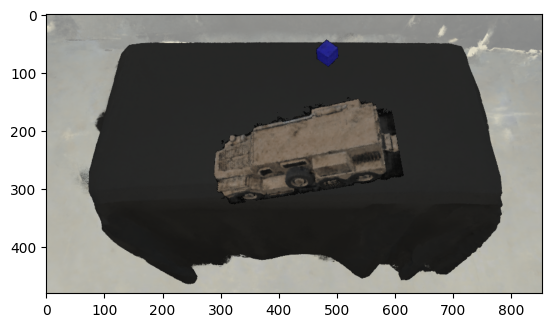

In [29]:
image_composed, points_composed, points_composed_world, points_2d = network()
plt.figure()
plt.imshow(image_composed)
colors = np.reshape(image_composed, (-1, 3))
colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
send_point_cloud(np.hstack((points_composed_world.detach().cpu().numpy(), colors)), has_alpha=False)

# tmp = np.ones(points_composed_world.shape)
# tmp[:, :2] = points_2d.detach().cpu().numpy()
# send_point_cloud(np.hstack((tmp, colors)), has_alpha=False, topic='point_cloud_2')
# print(torch.max(points_2d))

0.0262451171875


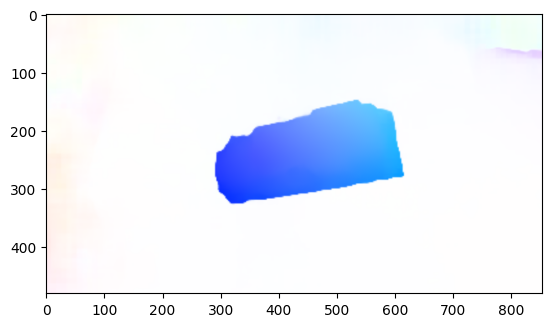

In [30]:
image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
image2 = ros_image[:,:,:3]
image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)

padding_factor=32
fixed_inference_size = None
fixed_inference_size = (int(448*.5), int(768*.5))

# the model is trained with size: width > height
transpose_img = False
if image1.size(-2) > image1.size(-1):
    image1 = torch.transpose(image1, -2, -1)
    image2 = torch.transpose(image2, -2, -1)
    transpose_img = True

nearest_size = [int(np.ceil(image1.size(-2) / padding_factor)) * padding_factor,
                int(np.ceil(image1.size(-1) / padding_factor)) * padding_factor]

# resize to nearest size or specified size
inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

assert isinstance(inference_size, list) or isinstance(inference_size, tuple)
ori_size = image1.shape[-2:]

# resize before inference
if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
    image1 = F.interpolate(image1, size=inference_size, mode='bilinear',
                           align_corners=True)
    image2 = F.interpolate(image2, size=inference_size, mode='bilinear',
                           align_corners=True)

    
for i in range(1):
    import time
    start = time.time()
    with torch.inference_mode():
        results_dict = model(image1, image2,
                            attn_type='swin',
                            attn_splits_list=[2, 8],
                            corr_radius_list=[-1, 4],
                            prop_radius_list=[-1, 1],
                            num_reg_refine=6,
                            task='flow'
                            )
    print(time.time() - start)

    
flow_pr = results_dict['flow_preds'][-1]

# resize back
if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
    flow_pr = F.interpolate(flow_pr, size=ori_size, mode='bilinear',
                            align_corners=True)
    flow_pr[:, 0] = flow_pr[:, 0] * ori_size[-1] / inference_size[-1]
    flow_pr[:, 1] = flow_pr[:, 1] * ori_size[-2] / inference_size[-2]

if transpose_img:
    flow_pr = torch.transpose(flow_pr, -2, -1)

flow = flow_pr[0].permute(1, 2, 0).cpu().numpy()  # [H, W, 2]

plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

In [31]:
import sys
sys.path.append('../unimatch_repo')
import torch
import torch.nn.functional as F
from unimatch.unimatch import UniMatch
from dataloader.stereo import transforms
from utils.visualization import viz_depth_tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_stereo = UniMatch(feature_channels=128,
                 num_scales=2,
                 upsample_factor=4,
                 num_head=1,
                 ffn_dim_expansion=4,
                 num_transformer_layers=6,
                 reg_refine=True,
                 task='stereo').to(device)

trained_depth_path = '../unimatch_repo/pretrained/gmstereo-scale2-regrefine3-resumeflowthings-middleburyfthighres-a82bec03.pth'
loc = 'cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(trained_depth_path, map_location=loc)
model_stereo.load_state_dict(checkpoint['model'], strict=False)
model_stereo.eval()



UniMatch(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
    

[WARN] [1695147684.653145114] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


0.1033027172088623


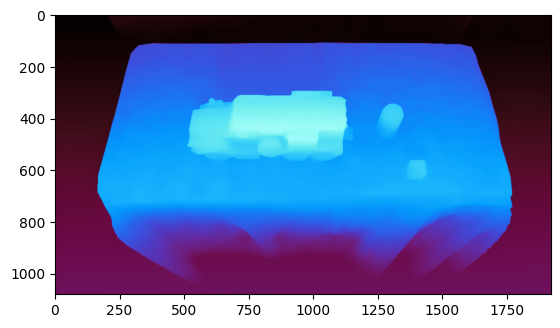

In [32]:
from utils.visualization import vis_disparity

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

left, left_pose = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
left_pose = left_pose[0]
left = left[0]

right, right_pose = get_image_tf_pair(image_topics=['camera_image_r'], tf_names=['camera_frame_r'])
right_pose = right_pose[0]
right = right[0]


padding_factor = 32

left = left[:,:,:3].astype(np.float32)
left_ori = left.copy() 
right = right[:,:,:3].astype(np.float32)


sample = {'left': left,
          'right': right
          }
val_transform_list = [transforms.ToTensor(), transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)]
val_transform = transforms.Compose(val_transform_list)
sample = val_transform(sample)
left = sample['left'].to(device).unsqueeze(0)  # [1, 3, H, W]
right = sample['right'].to(device).unsqueeze(0)  # [1, 3, H, W]

nearest_size = [int(np.ceil(left.size(-2) / padding_factor)) * padding_factor,
                int(np.ceil(left.size(-1) / padding_factor)) * padding_factor]

fixed_inference_size = [val//2 for val in nearest_size] 
# fixed_inference_size = None

# resize to nearest size or specified size
inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

ori_size = left.shape[-2:]

if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
    left = F.interpolate(left, size=inference_size,
                         mode='bilinear',
                         align_corners=True)
    right = F.interpolate(right, size=inference_size,
                          mode='bilinear',
                              align_corners=True)

with torch.no_grad():
    import time
    for i  in range(1):
        start = time.time()
        pred_disp = model_stereo(left, right,
                           attn_type='self_swin2d_cross_swin1d',
                           attn_splits_list=[2, 8],
                           prop_radius_list=[-1, 1],
                           corr_radius_list=[-1, 4],
                           num_reg_refine=3,
                           task='stereo',
                           )['flow_preds'][-1]  # [1, H, W]
        print(time.time() - start)



if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
    pred_disp = F.interpolate(pred_disp.unsqueeze(1), size=ori_size, mode='nearest').squeeze(1)  # [1, H, W]


disp = pred_disp[0].cpu().numpy()

plt.figure()
plt.imshow(vis_disparity(disp))


In [33]:
import math

# def get_points(depth, tf_cam_world_inv, fov, width, height):
#     fx = 2*np.tan(fov/2.0)
#     fy = fx*width/height
#     Z = depth
#     [Xgrid, Ygrid] = np.meshgrid(np.linspace(-.5, .5, width), np.linspace(-.5, .5, height))
#     X = (Xgrid)*Z/fx
#     Y = (Ygrid)*Z/fy
#     points = np.stack([X, Y, Z], axis=2);
#     points = np.reshape(points, (-1, 3))
#     points = (points @ tf_cam_world_inv[:3, :3].transpose()) + np.reshape(tf_cam_world_inv[:3, 3], (1, 3))
    
#     return points


baseline = np.sqrt(np.sum((left_pose[:3,3]-right_pose[:3,3])**2))
fov = 69.4*(math.pi/180.0)
focal = 2*np.tan(fov/2.0)
depth = baseline * focal / disp
depth = depth/2.0 # correct for scaling

points = 1000*get_points(depth, np.eye(4), math.pi*(42.5/180.0), depth.shape[1], depth.shape[0])
Rt = left_pose[:3, :3].transpose(0,1)
points = (points @ Rt) + np.reshape(left_pose[:3, 3], (1, 3)) 


tmp = left.cpu().numpy()
tmp = np.transpose(tmp, (0,2,3,1))
tmp = tmp*np.reshape(IMAGENET_STD, (1,1,1,3))
tmp = tmp + np.reshape(IMAGENET_MEAN, (1,1,1,3))

tmp = tmp

tmp = left_ori/255
tmp[tmp>1.0] = 1.0



print(depth.shape)

colors = np.reshape(tmp, (-1, 3))
colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
send_point_cloud(np.hstack((points, colors)), has_alpha=False)




(1080, 1920)
